# VU Econometics and Data Science: Case Study
```
Author(s): Jacco Broere
```


### Setup
- Setup config.ini file
- Install necessary packages
- Download and unpack data



In [26]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os
import time

# helper functions
from helpers.helper_functions import transform_data, add_actuals
from helpers.helper_classes import AddFeatureNames

# sklearn
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# LightGBM
from lightgbm import LGBMClassifier

# feature_engine
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
# Read config.ini file
config = configparser.ConfigParser()
if os.path.isfile('src/config.ini'):
    config.read('src/config.ini')
elif os.path.isfile('config.ini'):
    config.read('config.ini')
os.chdir(config['PATH']['ROOT_DIR'])

In [28]:
# Read data
raw_train = pd.read_csv(config['PATH']['RAW_TRAIN_DATA'])
raw_test = pd.read_csv(config['PATH']['RAW_TEST_DATA'])
actuals = pd.read_csv(config['PATH']['ACTUALS'])
raw_total = pd.concat([raw_train, raw_test], axis=1)

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

### Preprocessing

In [18]:
# Transform data to accesible format and add actuals
train = transform_data(raw_train)
train = add_actuals(train, actuals)
test = transform_data(raw_test)
test = add_actuals(test, actuals)
total = transform_data(raw_total)
total = add_actuals(total, actuals)

# get target variable
y_train = train["cancer"]
y_test = test["cancer"]
y_total = total["cancer"]

In [19]:
preprocessing_pipe = Pipeline([
    # Step 0:
        # Drop constant and duplicate features
        ('drop_features', DropFeatures(features_to_drop=["cancer"])),
        ('drop_constant', DropConstantFeatures(tol=0.98)),
    # Step 1:
        # Apply scaling to data as it is a requirement for the variance maximization procedure of PCA
        ('scaler', StandardScaler()),
])

X_train = preprocessing_pipe.fit_transform(train)
X_test = preprocessing_pipe.fit_transform(test)
X_total = preprocessing_pipe.fit_transform(total)

### PCA and SparsePCA

In [33]:
def create_pipe(clf, shrink_method='None', n=N_COMPONENTS):
    
    drop_constant = DropConstantFeatures(tol=0.98)
    scaler = StandardScaler()
    pca = PCA(n_components=n)
    spca = SparsePCA(n_components=n)
    add_features_names = AddFeatureNames(prefix="cmpnt_")

    if shrink_method == 'PCA':
        combined_features = FeatureUnion([("drop_constant", drop_constant), 
                                          ("scaler", scaler), 
                                          ("pca", pca),
                                          ("add_features_names", add_features_names)])
        
    elif shrink_method == 'SPCA':
        combined_features = FeatureUnion([("drop_constant", drop_constant), 
                                          ("scaler", scaler), 
                                          ("spca", spca),
                                          ("add_features_names", add_features_names)])
        
    elif shrink_method == 'None':
        combined_features = FeatureUnion([("drop_constant", drop_constant), 
                                          ("scaler", scaler), 
                                          ("add_features_names", add_features_names)])
        
    else:
        raise Exception("Input valid shrinking method from: {PCA, SPCA, None}")

        
    pipeline = Pipeline([("features", combined_features), 
                         ("clf", clf)])

    return pipeline

In [31]:
models = {'KNeighbors' : KNeighborsClassifier(),
          'RandomForest' : RandomForestClassifier(random_state=SEED),
          'LogisticReg' : LogisticRegression(random_state=SEED),
          'LGBMClassifier': LGBMClassifier(random_state=SEED)
          }
folds=5

def run_models(shrink: str, cv=folds):
    for name, model, in models.items():
        start = time.time()
        clf = model
        pipeline = create_pipe(clf, shrink_method=shrink, n=2)
        scores = cross_val_score(pipeline, 
                                 X_total,
                                 y_total,
                                 scoring='accuracy', 
                                 cv=cv, n_jobs=5, 
                                 error_score='raise')
        print(name, ': Mean Accuracy: %.3f and Standard Deviation: (%.3f) and Runtime: %.3f s' % (np.mean(scores), np.std(scores), time.time() - start))

print(f'N_COMPONENTS = {N_COMPONENTS}, SEED = {SEED}, CV = {folds}')
print(68 * '-')
print('None')
print(68 * '-')
run_models(shrink='None')
print(68 * '-')
print('PCA')
print(68 * '-')
run_models(shrink='PCA')
print(68 * '-')
print('SPCA')
print(68 * '-')
run_models(shrink='SPCA')
print(68 * '-')

N_COMPONENTS = 10, SEED = 2023, CV = 5
--------------------------------------------------------------------
None
--------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.790 and Standard Deviation: (0.103) and Runtime: 4.216 s


KeyboardInterrupt: 

In [ ]:
def get_params(parameters, X, y, pipeline):

    grid = GridSearchCV(pipeline, 
                        parameters, 
                        scoring='accuracy', 
                        n_jobs=1, 
                        cv=3, 
                        error_score='raise')
    grid.fit(X, y)

    return grid

# clf = LogisticRegression(random_state=SEED)
# pipeline = create_pipe(clf, shrink_method='PCA')

# param_grid = dict(features__pca__n_components = list(range(1,10)),
#                  clf__C = [0.1, 1.0, 10, 100],
#                  clf__solver = ['liblinear', 'saga'],
#                  clf__penalty = ['l2', 'l1'])

# grid = get_params(param_grid, X_train, y_train, pipeline)

# print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
# print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
# print("Best parameters: {}".format(grid.best_params_))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.80      1.00      0.89        20

    accuracy                           0.85        34
   macro avg       0.90      0.82      0.84        34
weighted avg       0.88      0.85      0.85        34



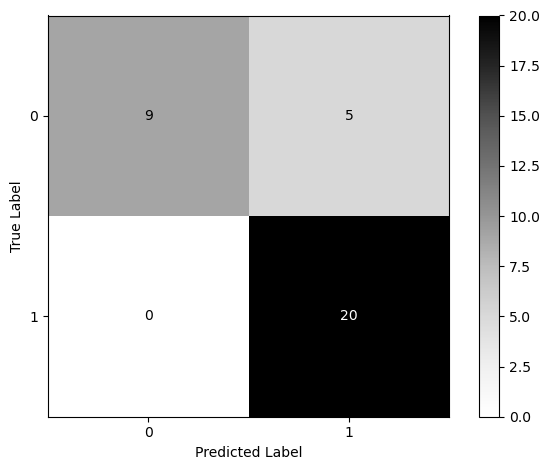

In [37]:
def fit_and_print(pipeline):

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=2))

    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Greys)

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show; 
    
clf = LogisticRegression(C=10, penalty='l1', solver='liblinear', random_state=41)
pipeline = create_pipe(clf, shrink_method='SPCA', n=2)
fit_and_print(pipeline)